### Устанвока.

In [2]:
%pip install scikit-learn
%pip install phik
%pip install scipy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Импорты, загрузка данных и работа с данными.

Распределение классов:
NObeyesdad
Obesity_Type_I         0.166272
Obesity_Type_III       0.153482
Obesity_Type_II        0.140692
Overweight_Level_I     0.137376
Overweight_Level_II    0.137376
Normal_Weight          0.135955
Insufficient_Weight    0.128849
Name: proportion, dtype: float64

Абсолютные значения:
NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight              

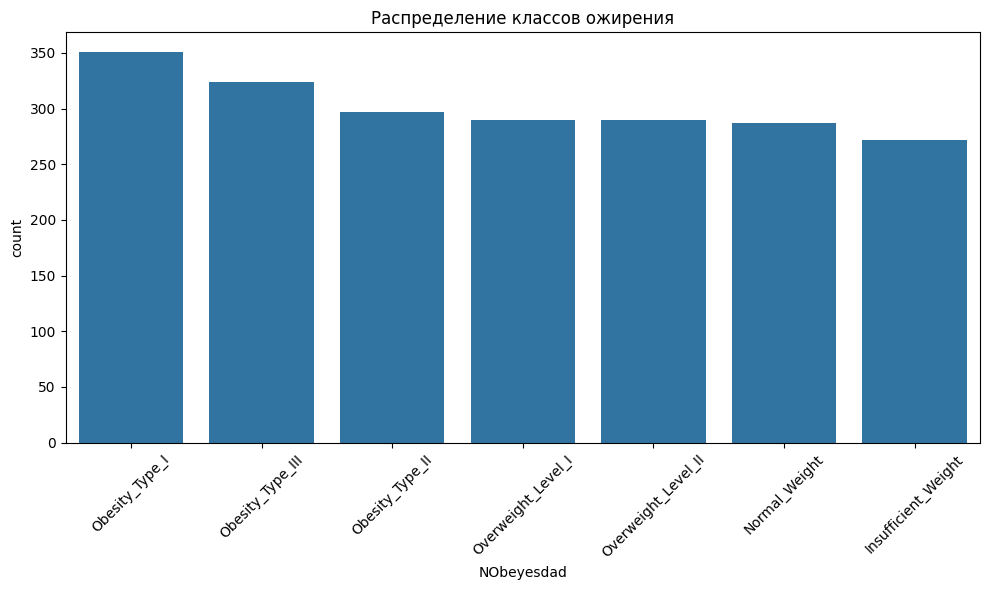


Категориальные признаки: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']
Числовые признаки: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']


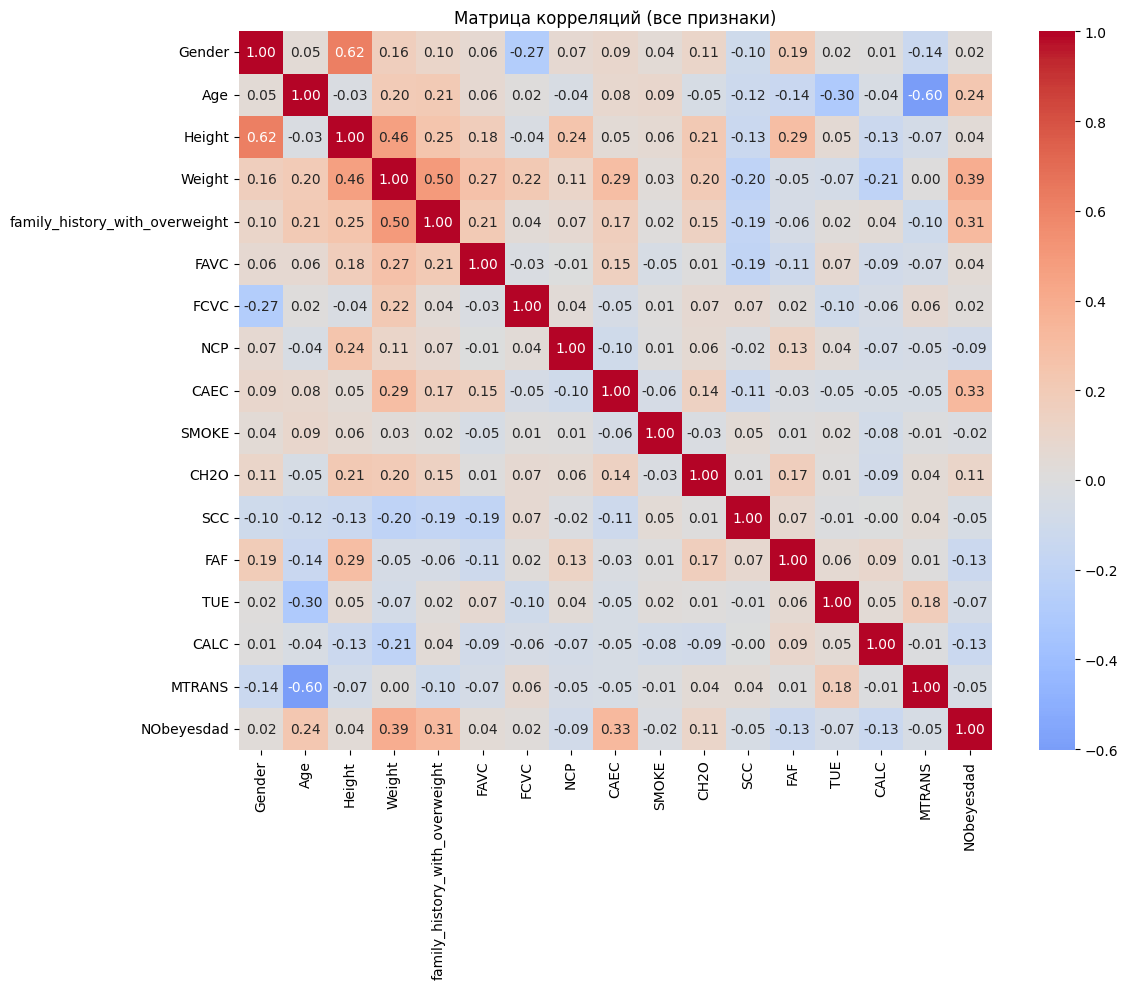

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
from phik import phik_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
df = pd.read_csv('ObesityDataSet.csv')

# Анализ распределения целевой переменной
print("Распределение классов:")
print(df['NObeyesdad'].value_counts(normalize=True))
print("\nАбсолютные значения:")
print(df['NObeyesdad'].value_counts())

# Основная информация о датасете
print("\nИнформация о датасете:")
print(df.info())
print(f"\nРазмер датасета: {df.shape}")

# Просмотр первых строк данных
print("\nПервые 5 строк данных:")
print(df.head())

# Проверка на пропущенные значения
print("\nПропущенные значения:")
print(df.isnull().sum())

# Статистическое описание числовых признаков
print("\nСтатистическое описание числовых признаков:")
print(df.describe())

# Визуализация распределения целевой переменной
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='NObeyesdad', order=df['NObeyesdad'].value_counts().index)
plt.title('Распределение классов ожирения')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Анализ категориальных признаков
categorical_columns = df.select_dtypes(include=['object']).columns
print(f"\nКатегориальные признаки: {list(categorical_columns)}")

# Анализ числовых признаков
numerical_columns = df.select_dtypes(include=[np.number]).columns
print(f"Числовые признаки: {list(numerical_columns)}")

# Кодирование категориальных переменных для анализа
df_encoded = df.copy()
label_encoders = {}

for col in categorical_columns:
    if col != 'NObeyesdad':  # Не кодируем целевую переменную пока
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

# Кодирование целевой переменной
target_encoder = LabelEncoder()
df_encoded['NObeyesdad_encoded'] = target_encoder.fit_transform(df['NObeyesdad'])

# Кодирование всех категориальных признаков
df_encoded = df.copy()

for column in df_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column].astype(str))

# Матрица корреляций 
plt.figure(figsize=(12, 10))
correlation_matrix = df_encoded.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Матрица корреляций (все признаки)')
plt.tight_layout()


### Перевод навзаний столбцов.
 1. Gender                                → Пол
 2. Age                                   → Возраст
 3. Height                                → Рост
 4. Weight                                → Вес
 5. family_history_with_overweight        → Семейная_история_лишнего_веса
 6. FAVC                                  → Частое_употребление_высококалорийной_еды
 7. FCVC                                  → Частота_употребления_овощей
 8. NCP                                   → Количество_основных_приемов_пищи
 9. CAEC                                  → Питание_между_приемами_пищи
10. SMOKE                                 → Курение
11. CH2O                                  → Потребление_воды
12. SCC                                   → Мониторинг_калорий
13. FAF                                   → Физическая_активность
14. TUE                                   → Время_за_электронными_устройствами
15. CALC                                  → Потребление_алкоголя
16. MTRANS                                → Тип_транспорта
17. NObeyesdad                            → Уровень_ожирения

### Типы данных.

In [4]:
df.dtypes

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

### Разделение выборок.

In [5]:
# Разделение на признаки и целевую переменную
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=777)

# Анализ распределения классов в выборках
print('Тренировочная выборка:\n', y_train.value_counts(normalize=True), sep='')
print('Тестовая выборка:\n', y_test.value_counts(normalize=True), sep='')

Тренировочная выборка:
NObeyesdad
Obesity_Type_I         0.166772
Obesity_Type_III       0.152874
Overweight_Level_II    0.140872
Obesity_Type_II        0.140240
Insufficient_Weight    0.135818
Overweight_Level_I     0.133923
Normal_Weight          0.129501
Name: proportion, dtype: float64
Тестовая выборка:
NObeyesdad
Obesity_Type_I         0.164773
Obesity_Type_III       0.155303
Normal_Weight          0.155303
Overweight_Level_I     0.147727
Obesity_Type_II        0.142045
Overweight_Level_II    0.126894
Insufficient_Weight    0.107955
Name: proportion, dtype: float64


### Преобразование в категориальные данные.

In [6]:
df['FCVC'] = df['FCVC'].round(0) # Частота употребления овощей
df['NCP'] = df['NCP'].round(0) # Количество основных приемов пищи
df['CH2O'] = df['CH2O'].round(0) # Потребление воды в день
df['FAF'] = df['FAF'].round(0) # Частота физической активности
df['TUE'] = df['TUE'].round(0) # Время использования электронных устройств

In [7]:
categorical_numeric_features = ['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

print("Типы данных до преобразования:")
print(df[categorical_numeric_features].dtypes)

Типы данных до преобразования:
FCVC    float64
NCP     float64
CH2O    float64
FAF     float64
TUE     float64
dtype: object


In [8]:
# Преобразуем в категориальный тип
for col in categorical_numeric_features:
    df[col] = df[col].astype('category')

print("\nТипы данных после преобразования:")
print(df[categorical_numeric_features].dtypes)
binary_columns = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
binary_mapping = {'Female': 0, 'Male': 1, 'no': 0, 'yes': 1}

for col in binary_columns:
    df[col] = df[col].map(binary_mapping)


Типы данных после преобразования:
FCVC    category
NCP     category
CH2O    category
FAF     category
TUE     category
dtype: object


# Построение деревьев

In [18]:

df = pd.read_csv('ObesityDataSet.csv')

df['BMI'] = df['Weight'] / (df['Height'] ** 2)

In [19]:
# Преобразование целевой переменной в числовой формат
obesity_levels = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}
df['NObeyesdad_num'] = df['NObeyesdad'].map(obesity_levels)

# Разделение на признаки и целевую переменную
X = df[['BMI', 'NCP']]
y = df['NObeyesdad_num']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=777)

# Анализ распределения классов в выборках
print('Тренировочная выборка:\n', y_train.value_counts(normalize=True), sep='')
print('Тестовая выборка:\n', y_test.value_counts(normalize=True), sep='')

Тренировочная выборка:
NObeyesdad_num
4    0.166772
6    0.152874
3    0.140872
5    0.140240
0    0.135818
2    0.133923
1    0.129501
Name: proportion, dtype: float64
Тестовая выборка:
NObeyesdad_num
4    0.164773
6    0.155303
1    0.155303
2    0.147727
5    0.142045
3    0.126894
0    0.107955
Name: proportion, dtype: float64


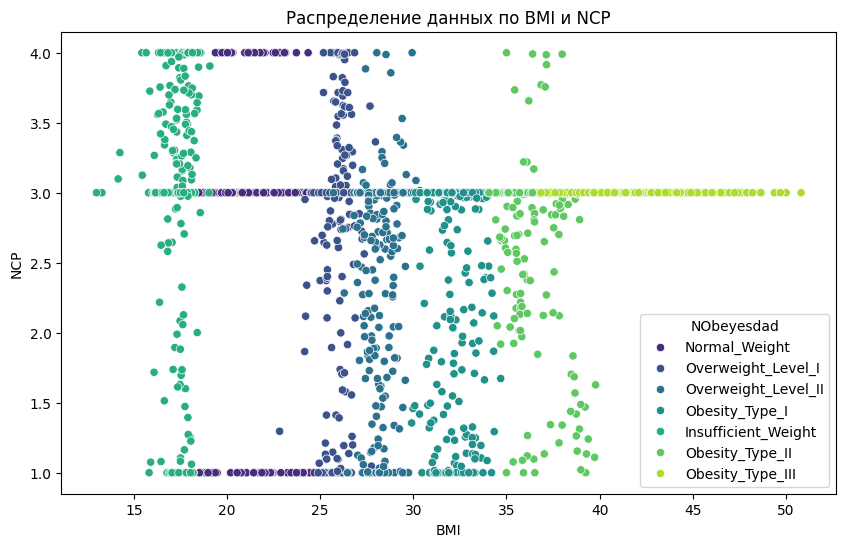

In [12]:
# Визуализация данных
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='BMI',
    y='NCP',
    hue='NObeyesdad',
    palette='viridis'
)
plt.title('Распределение данных по BMI и NCP')
plt.show()

In [13]:
dt_simple = DecisionTreeClassifier(random_state=42)
dt_simple.fit(X_train, y_train)

NameError: name 'DecisionTreeClassifier' is not defined

In [14]:
plt.figure(figsize=(15, 10))
plot_tree(
    dt_simple,
    feature_names=['BMI', 'NCP'],
    class_names=list(obesity_levels.keys()),
    filled=True,
)
plt.title('Дерево решений для BMI и NCP')
plt.show()


NameError: name 'plot_tree' is not defined

<Figure size 1500x1000 with 0 Axes>

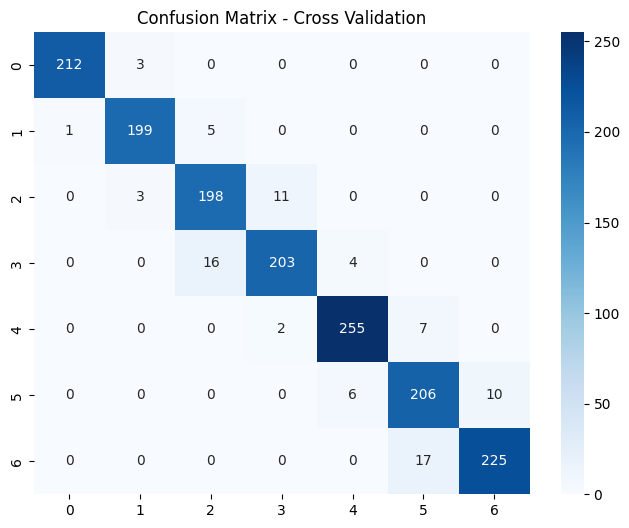

                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.99      0.99       215
      Normal_Weight       0.97      0.97      0.97       205
 Overweight_Level_I       0.90      0.93      0.92       212
Overweight_Level_II       0.94      0.91      0.92       223
     Obesity_Type_I       0.96      0.97      0.96       264
    Obesity_Type_II       0.90      0.93      0.91       222
   Obesity_Type_III       0.96      0.93      0.94       242

           accuracy                           0.95      1583
          macro avg       0.95      0.95      0.95      1583
       weighted avg       0.95      0.95      0.95      1583



In [ ]:
y_pred_simple = dt_simple.predict(X_train)
y_pred_cv_simple = cross_val_predict(dt_simple, X_train, y_train, cv=5)


plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_train, y_pred_cv_simple), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Cross Validation')
plt.show()

report_cv = classification_report(y_train, y_pred_cv_simple, target_names=obesity_levels.keys())
print(report_cv)


Лучшие параметры: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 2}
Лучшее качество на кросс-валидации: 0.956
Classification Report - CV with Best Params:
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.98      0.99       215
      Normal_Weight       0.97      0.99      0.98       205
 Overweight_Level_I       0.96      0.94      0.95       212
Overweight_Level_II       0.95      0.96      0.96       223
     Obesity_Type_I       0.99      0.95      0.97       264
    Obesity_Type_II       0.85      0.99      0.91       222
   Obesity_Type_III       0.99      0.89      0.94       242

           accuracy                           0.96      1583
          macro avg       0.96      0.96      0.96      1583
       weighted avg       0.96      0.96      0.96      1583



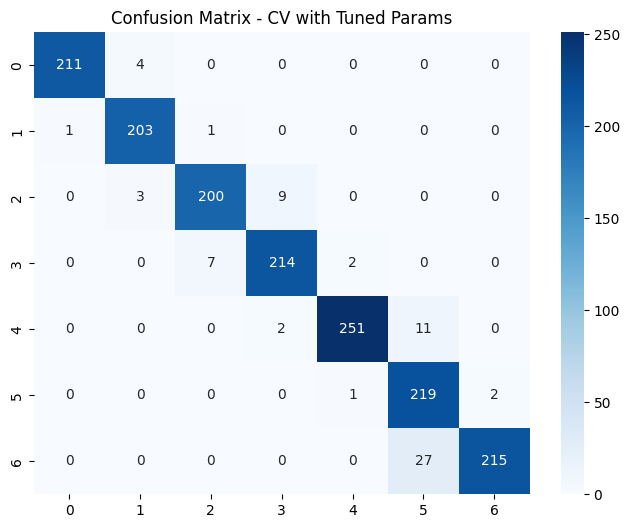

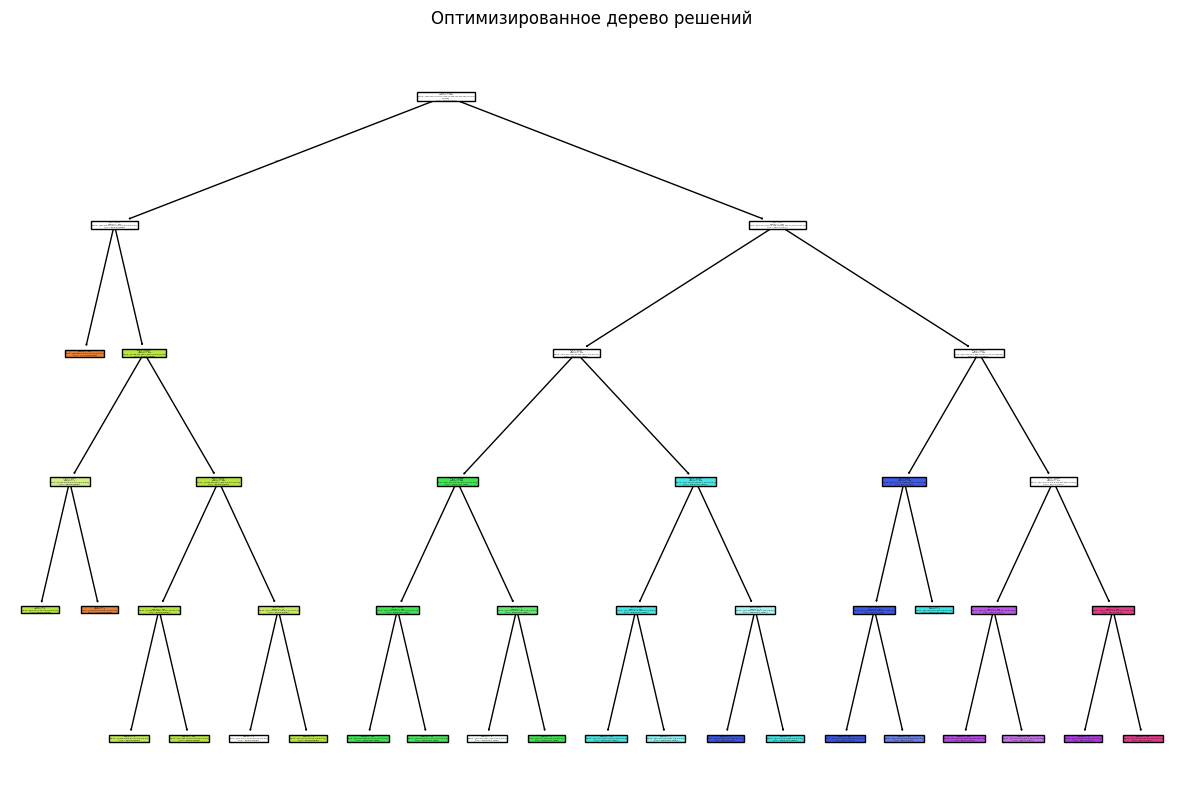

In [ ]:
# Подбор гиперпараметров для простой модели
dtc = DecisionTreeClassifier(random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'max_depth': range(2, 11),
    'min_samples_leaf': range(1, 6),
    'class_weight': [None, 'balanced']
}

gs = GridSearchCV(dtc, param_grid=param_grid, cv=skf, scoring='f1_weighted', n_jobs=-1)
gs.fit(X_train, y_train)

print(f'Лучшие параметры: {gs.best_params_}')
print(f'Лучшее качество на кросс-валидации: {gs.best_score_:.3f}')

y_pred_cv = cross_val_predict(gs.best_estimator_, X_train, y_train, cv=skf, n_jobs=-1)
print("Classification Report - CV with Best Params:")
print(classification_report(y_train, y_pred_cv, target_names=obesity_levels.keys()))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_train, y_pred_cv), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - CV with Tuned Params')
plt.show()

# Визуализация лучшего дерева
plt.figure(figsize=(15, 10))
plot_tree(
    gs.best_estimator_,
    feature_names=['BMI', 'NCP'],
    class_names=list(obesity_levels.keys()),
    filled=True,
)
plt.title('Оптимизированное дерево решений')
plt.show()


In [21]:
# Обучение на всех признаках (кроме целевых)
features_to_drop = ['NObeyesdad', 'NObeyesdad_num', 'BMI']  # BMI уже добавлен отдельно
numeric_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI']
categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

# Преобразование категориальных признаков
X_full = pd.get_dummies(df[numeric_features + categorical_features], columns=categorical_features)
y_full = df['NObeyesdad_num']

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y_full, random_state=42, stratify=y_full
)

Лучшие параметры (полная модель): {'class_weight': None, 'max_depth': 8, 'min_samples_leaf': 1}
Лучшее качество на кросс-валидации (полная модель): 0.972
Classification Report - Full Model CV:
                     precision    recall  f1-score   support

Insufficient_Weight       0.97      0.98      0.98       204
      Normal_Weight       0.95      0.96      0.96       215
 Overweight_Level_I       0.96      0.94      0.95       217
Overweight_Level_II       0.97      0.95      0.96       218
     Obesity_Type_I       0.97      0.98      0.97       263
    Obesity_Type_II       0.98      0.98      0.98       223
   Obesity_Type_III       1.00      1.00      1.00       243

           accuracy                           0.97      1583
          macro avg       0.97      0.97      0.97      1583
       weighted avg       0.97      0.97      0.97      1583



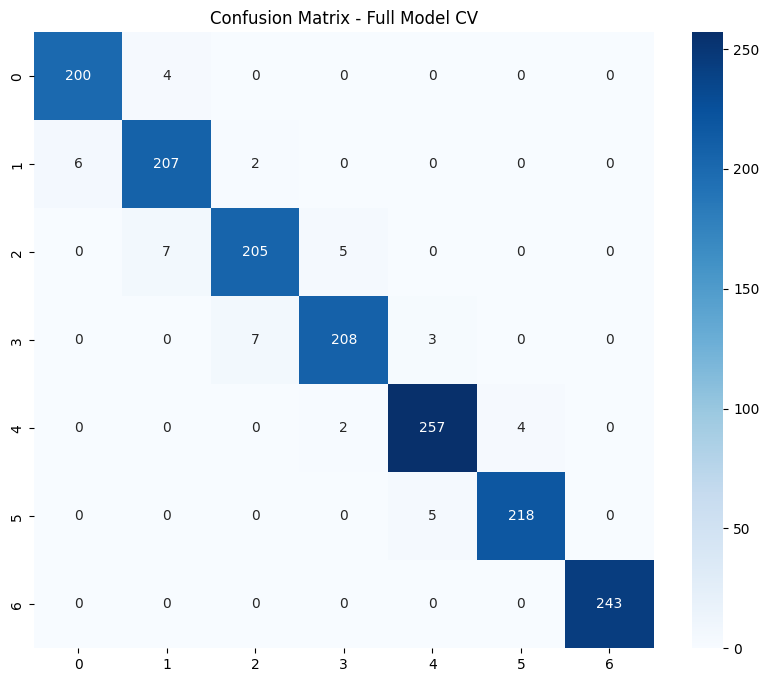

In [ ]:
# Подбор гиперпараметров для полной модели
dtc_full = DecisionTreeClassifier(random_state=42)

param_grid_full = {
    'max_depth': range(2, 11),
    'min_samples_leaf': range(1, 6),
    'class_weight': [None, 'balanced']
}

gs_full = GridSearchCV(dtc_full, param_grid=param_grid_full, cv=skf, scoring='f1_weighted', n_jobs=-1)
gs_full.fit(X_train_full, y_train_full)

print(f'Лучшие параметры (полная модель): {gs_full.best_params_}')
print(f'Лучшее качество на кросс-валидации (полная модель): {gs_full.best_score_:.3f}')

y_pred_cv_full = cross_val_predict(gs_full.best_estimator_, X_train_full, y_train_full, cv=skf, n_jobs=-1)
print("Classification Report - Full Model CV:")
print(classification_report(y_train_full, y_pred_cv_full, target_names=obesity_levels.keys()))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_train_full, y_pred_cv_full), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Full Model CV')
plt.show()


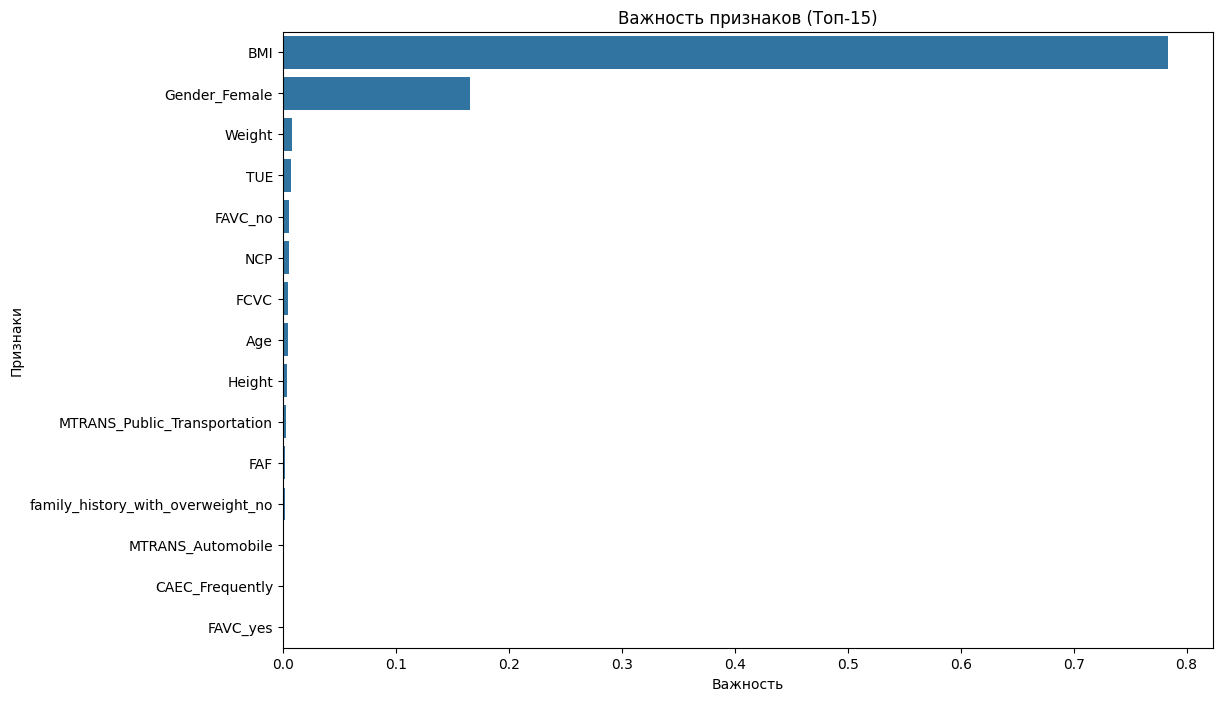

In [ ]:
# Анализ важности признаков
feature_importances = gs_full.best_estimator_.feature_importances_
features = X_train_full.columns

plt.figure(figsize=(12, 8))
feature_imp_df = pd.DataFrame({'feature': features, 'importance': feature_importances})
feature_imp_df = feature_imp_df.sort_values('importance', ascending=False).head(15)

sns.barplot(data=feature_imp_df, x='importance', y='feature')
plt.title('Важность признаков (Топ-15)')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.show()

Classification Report - Full Model CV:
                     precision    recall  f1-score   support

Insufficient_Weight       0.97      0.99      0.98       204
      Normal_Weight       0.96      0.94      0.95       215
 Overweight_Level_I       0.94      0.92      0.93       217
Overweight_Level_II       0.95      0.95      0.95       218
     Obesity_Type_I       0.99      0.99      0.99       263
    Obesity_Type_II       0.99      1.00      0.99       223
   Obesity_Type_III       1.00      1.00      1.00       243

           accuracy                           0.97      1583
          macro avg       0.97      0.97      0.97      1583
       weighted avg       0.97      0.97      0.97      1583



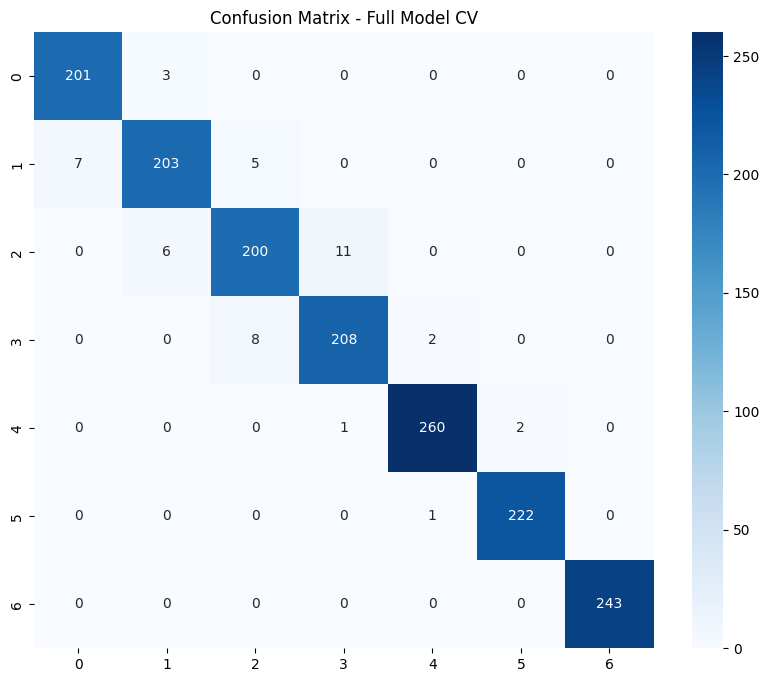

In [25]:
from sklearn import svm
from sklearn.model_selection import cross_val_predict, StratifiedKFold
clf = svm.SVC(kernel='linear')
clf.fit(X_train_full, y_train_full)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_pred_cv_full = cross_val_predict(estimator=clf, X=X_train_full, y=y_train_full, cv=skf, n_jobs=-1)

print("Classification Report - Full Model CV:")
print(classification_report(y_train_full, y_pred_cv_full, target_names=obesity_levels.keys()))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_train_full, y_pred_cv_full), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Full Model CV')
plt.show()

Classification Report - Full Model CV:
                     precision    recall  f1-score   support

Insufficient_Weight       0.76      0.94      0.84       204
      Normal_Weight       0.72      0.46      0.56       215
 Overweight_Level_I       0.60      0.63      0.62       217
Overweight_Level_II       0.48      0.67      0.56       218
     Obesity_Type_I       0.78      0.56      0.65       263
    Obesity_Type_II       0.84      0.88      0.86       223
   Obesity_Type_III       0.95      0.94      0.94       243

           accuracy                           0.72      1583
          macro avg       0.73      0.73      0.72      1583
       weighted avg       0.74      0.72      0.72      1583



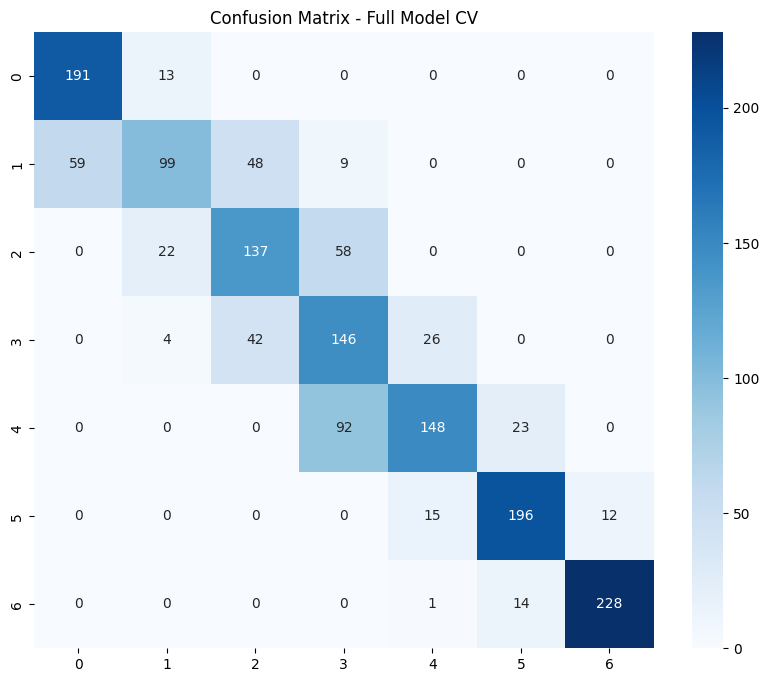

In [ ]:
clf = svm.SVC(
    kernel='rbf',  # тип ядра
    C=1.0,         # параметр регуляризации
    gamma='scale', # коэффициент для ядра
    random_state=42
)
clf.fit(X_train_full, y_train_full)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_pred_cv_full = cross_val_predict(estimator=clf, X=X_train_full, y=y_train_full, cv=skf, n_jobs=-1)

print("Classification Report - Full Model CV:")
print(classification_report(y_train_full, y_pred_cv_full, target_names=obesity_levels.keys()))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_train_full, y_pred_cv_full), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Full Model CV')
plt.show()

Classification Report - Full Model CV:
                     precision    recall  f1-score   support

Insufficient_Weight       0.79      0.99      0.88       204
      Normal_Weight       0.91      0.56      0.69       215
 Overweight_Level_I       0.67      0.82      0.74       217
Overweight_Level_II       0.81      0.77      0.79       218
     Obesity_Type_I       0.96      0.94      0.95       263
    Obesity_Type_II       0.96      0.91      0.94       223
   Obesity_Type_III       0.95      0.99      0.97       243

           accuracy                           0.86      1583
          macro avg       0.86      0.85      0.85      1583
       weighted avg       0.87      0.86      0.86      1583



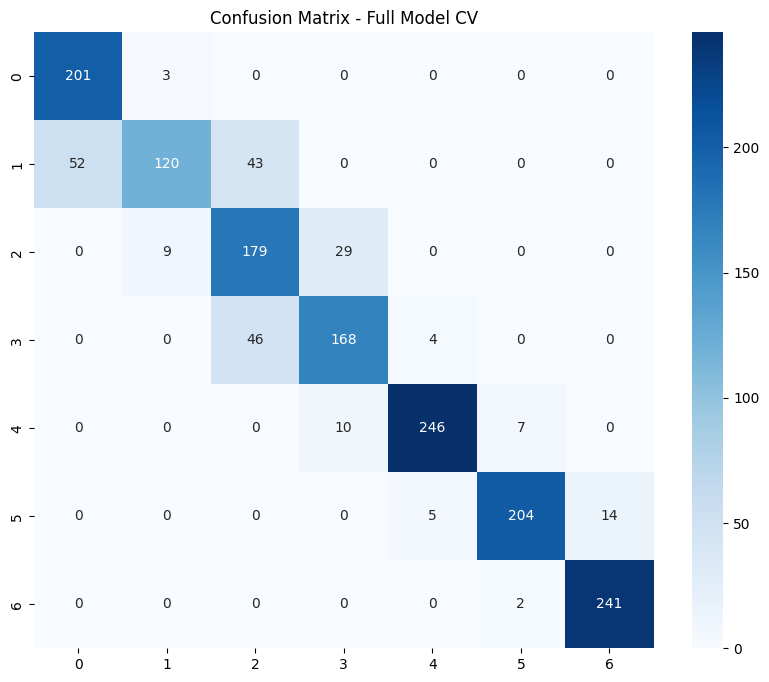

In [ ]:
clf = svm.SVC(kernel='poly', degree=3, gamma='scale', coef0=1.0)

clf.fit(X_train_full, y_train_full)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_pred_cv_full = cross_val_predict(estimator=clf, X=X_train_full, y=y_train_full, cv=skf, n_jobs=-1)

print("Classification Report - Full Model CV:")
print(classification_report(y_train_full, y_pred_cv_full, target_names=obesity_levels.keys()))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_train_full, y_pred_cv_full), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Full Model CV')
plt.show()

In [34]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'linear']
}

grid_search = GridSearchCV(
    svm.SVC(random_state=42),
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

grid_search.fit(X_train_full, y_train_full)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность:", grid_search.best_score_)

Лучшие параметры: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Лучшая точность: 0.9809375647438013


Classification Report - Full Model CV:
                     precision    recall  f1-score   support

Insufficient_Weight       0.96      0.99      0.97       204
      Normal_Weight       0.97      0.93      0.95       215
 Overweight_Level_I       0.97      0.97      0.97       217
Overweight_Level_II       0.98      0.98      0.98       218
     Obesity_Type_I       0.98      0.99      0.99       263
    Obesity_Type_II       1.00      1.00      1.00       223
   Obesity_Type_III       1.00      1.00      1.00       243

           accuracy                           0.98      1583
          macro avg       0.98      0.98      0.98      1583
       weighted avg       0.98      0.98      0.98      1583



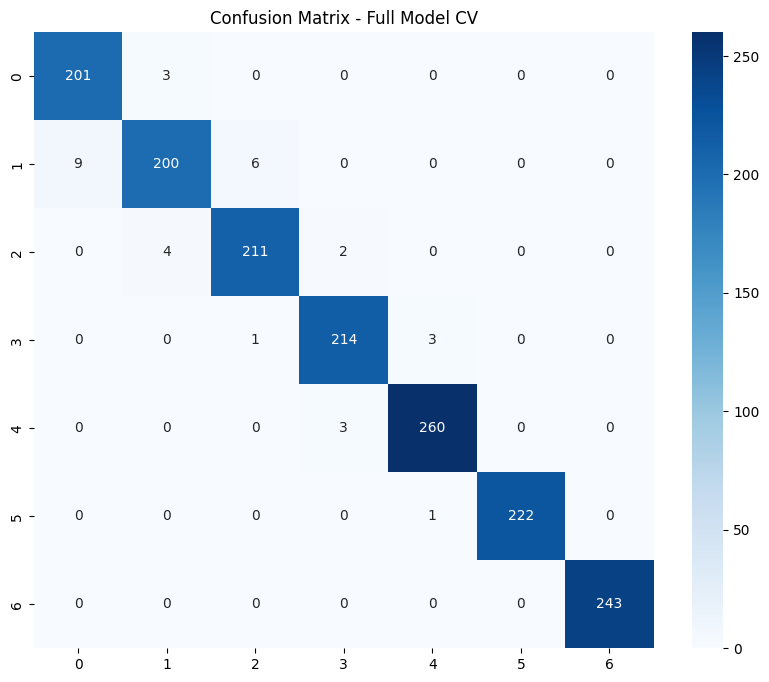

In [36]:
clf = svm.SVC(
    kernel='rbf',  # тип ядра
    C=10.0,         # параметр регуляризации
    gamma=0.01, # коэффициент для ядра
    random_state=42
)
clf.fit(X_train_full, y_train_full)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_pred_cv_full = cross_val_predict(estimator=clf, X=X_train_full, y=y_train_full, cv=skf, n_jobs=-1)

print("Classification Report - Full Model CV:")
print(classification_report(y_train_full, y_pred_cv_full, target_names=obesity_levels.keys()))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_train_full, y_pred_cv_full), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Full Model CV')
plt.show()

### Таким образом видим, что при подборе гиперпараметров у нас лучшее предсказание дает модель с радиальным базисным ядром (RBF), с параметром регуляризации C=10.0, и коэффициентом ядра gamma=0.01

В качестве метрики для задачи многоклассовой классификации ожирения лучше всего подходит метрика weighted F1-score. Выбор упал на нее, так как она учитывает дисбаланс классов и балансирует precision и recall, что также важно для нашей задачи. Если в нашей задаче мы будем использовать просто recall, то модель может достичь высокого recall для критических классов, просто помечая всех людей как "с ожирением". Важно брать именно weighted, так как в нашей задаче классы между собой не сбалансированы, и при обычном F1-score может возникать ошибка в вычислениях.

В качестве вторичной метрики сравнения моделей можно использовать макро-усредненный Recall, что позволит не пропустить в реальном случае людей с ожирением, которым действительно нужна помощь.